# Import and consts

In [1]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.transforms import Bbox
import cycler

import numpy as np
import pandas as pd
import pyodbc as db
import scipy.special
import scipy.stats
from girth import pcm_mml
import locale
from docx import Document
from docx.shared import Inches

In [2]:
driver = "{ODBC Driver 17 for SQL Server}"
server = "DESKTOP-U9RQTGC"
database = "ege"

images_path = "images/"  # Нужно создавать папку
template_doc_name = "stat_analysis_template.docx"

year = 2021
subject = 1
versions = []

subject_names = {
    1: "Русский язык",
    2: "Математика профильная",
    22: "Математика базовая",
    3: "Физика",
    4: "Химия",
    5: "Информатика и ИКТ",
    25: "Информатика и ИКТ (КЕГЭ)",
    6: "Биология",
    7: "История",
    8: "География",
    9: "Английский язык",
    10: "Немецкий язык",
    11: "Французский язык",
    12: "Обществознание",
    13: "Испанский язык",
    14: "Китайский язык",
    18: "Литература",
}

plot_dpi = 300
plot_size_cm = (16.666 * 1.2, 10.0)
plot_size_inch = (plot_size_cm[0] / 2.54, plot_size_cm[1] / 2.54)

bins = 12
irt_points = 80
irt_abilities_min = -5
irt_abilities_max = 5

In [3]:
pd.set_option("display.width", 150)
pd.set_option("display.precision", 2)
pd.set_option("mode.chained_assignment", "raise")

_ = locale.setlocale(locale.LC_ALL, "ru_RU")

In [4]:
def rangei(start, stop, step=1):
    return range(start, stop + 1, step)

# Loading results

In [5]:
def get_versions_in_sql():
    versions_sql = " "
    if len(versions) != 0:
        versions_sql = " and version in( "
        for v in versions:
            versions_sql += str(v) + ", "
        versions_sql += ")"

    return versions_sql


def get_last_task_number(cursor):
    last_number = cursor.execute(
        """
        select max(t4.number) as max
        from answers as t1 join exam_cases as t2
            on t1.exam_case_id = t2.exam_case_id
        join exams as t3 
            on t2.exam_id = t3.exam_id
        join tasks as t4
            on t4.task_id = t1.task_id
        where year = %d and t3.subject_id = %d
        """
        % (year, subject)
    ).fetchval()
    return last_number


def get_rows_with_all_results(cursor):
    versions_sql = get_versions_in_sql()
    rows = cursor.execute(
        """
 select answer_id, t4.number, points
        from answers as t1 join exam_cases as t2
            on t1.exam_case_id = t2.exam_case_id
        join exams as t3 
            on t2.exam_id = t3.exam_id
        join tasks as t4
            on t4.task_id = t1.task_id
        where year = %d and  t3.subject_id = %d %s
        order by answer_id
        """
        % (year, subject, versions_sql)
    ).fetchall()
    return rows


def convert_rows_to_dataframe(rows, last_task_number):
    rows_list = []
    dict1 = {}
    for row in rows:
        dict1.update([(str(row.number), row.points)])
        if row.number == last_task_number:
            rows_list.append(dict1.copy())
    return pd.DataFrame(rows_list)


def get_dichotomy_and_not_dichotomy_tasks(cursor):
    versions_sql = get_versions_in_sql()
    rows = cursor.execute(
        """
        select t4.number, max(points) as max_points
        from answers as t1 join exam_cases as t2
            on t1.exam_case_id = t2.exam_case_id
        join exams as t3 
            on t2.exam_id = t3.exam_id
        join tasks as t4
            on t4.task_id = t1.task_id
        where year = %d and t3.subject_id = %d %s
        group by t4.number
        """
        % (year, subject, versions_sql)
    ).fetchall()

    dichotomy_tasks = []
    not_dichotomy_tasks = []
    for row in rows:
        if row.max_points == 1:
            dichotomy_tasks.append(str(row.number))
        else:
            not_dichotomy_tasks.append(str(row.number))

    return dichotomy_tasks, not_dichotomy_tasks


def get_results(cursor):
    last_task_number = get_last_task_number(cursor)
    rows = get_rows_with_all_results(cursor)
    print("Результаты в сыром виде загружены из базы данных")
    all_results = convert_rows_to_dataframe(rows, last_task_number)
    print("Результаты преобразованы в табличную форму")
    (
        dichotomy_tasks,
        not_dichotomy_tasks,
    ) = get_dichotomy_and_not_dichotomy_tasks(cursor)

    dichotomy_results = all_results.loc[:, dichotomy_tasks]
    not_dichotomy_results = all_results.loc[:, not_dichotomy_tasks]

    results_stats = pd.DataFrame()
    results_stats["pp_total_dichotomy"] = dichotomy_results.sum(axis=1)
    results_stats["pp_total_not_dichotomy"] = not_dichotomy_results.sum(axis=1)
    results_stats["pp_total_all"] = all_results.sum(axis=1)

    return all_results, dichotomy_results, not_dichotomy_results, results_stats

In [6]:
conn_str = "DRIVER=%s;SERVER=%s;DATABASE=%s;Trusted_Connection=yes;" % (
    driver,
    server,
    database,
)
conn = db.connect(conn_str)
conn.autocommit = True
cursor = conn.cursor()
print("Соединение с сервером установлено")
cursor.fast_executemany = True

Соединение с сервером установлено


In [7]:
(
    all_results,
    dichotomy_results,
    not_dichotomy_results,
    results_stats,
) = get_results(cursor)

Результаты в сыром виде загружены из базы данных
Результаты преобразованы


In [8]:
cursor.close()
conn.close()
print("Соединение с сервером прекращено")

Соединение с сервером прекращено


# Init

In [9]:
result_count = all_results.shape[0]

dichotomy_task_count = len(dichotomy_results.columns)
not_dichotomy_task_count = len(not_dichotomy_results.columns)
all_task_count = len(all_results.columns)


In [10]:
fig = plt.figure(figsize=plot_size_inch, dpi=plot_dpi, facecolor="white")

<Figure size 2362.11x1181.1 with 0 Axes>

In [11]:
doc_content = {}


def add_content_to_doc(part, content_type, content=None, bbox_inches="tight"):
    if part not in doc_content.keys():
        doc_content.update({part: list()})

    content_dict = {}
    if content_type == "text":
        content_dict = {"type": "text", "text": content}

    elif content_type == "image":
        index = len(doc_content[part]) + 1
        path = f"{images_path}{part}.{index}.png"
        content_dict = {"type": "image", "path": path}
        fig = content
        fig.savefig(path, bbox_inches=bbox_inches)

    doc_content[part].append(content_dict)


# Stat. analysis. Part 1

Выполнение статистического анализа
Часть 1. Анализ в рамках классической теории тестов
1.1. Графики распределений


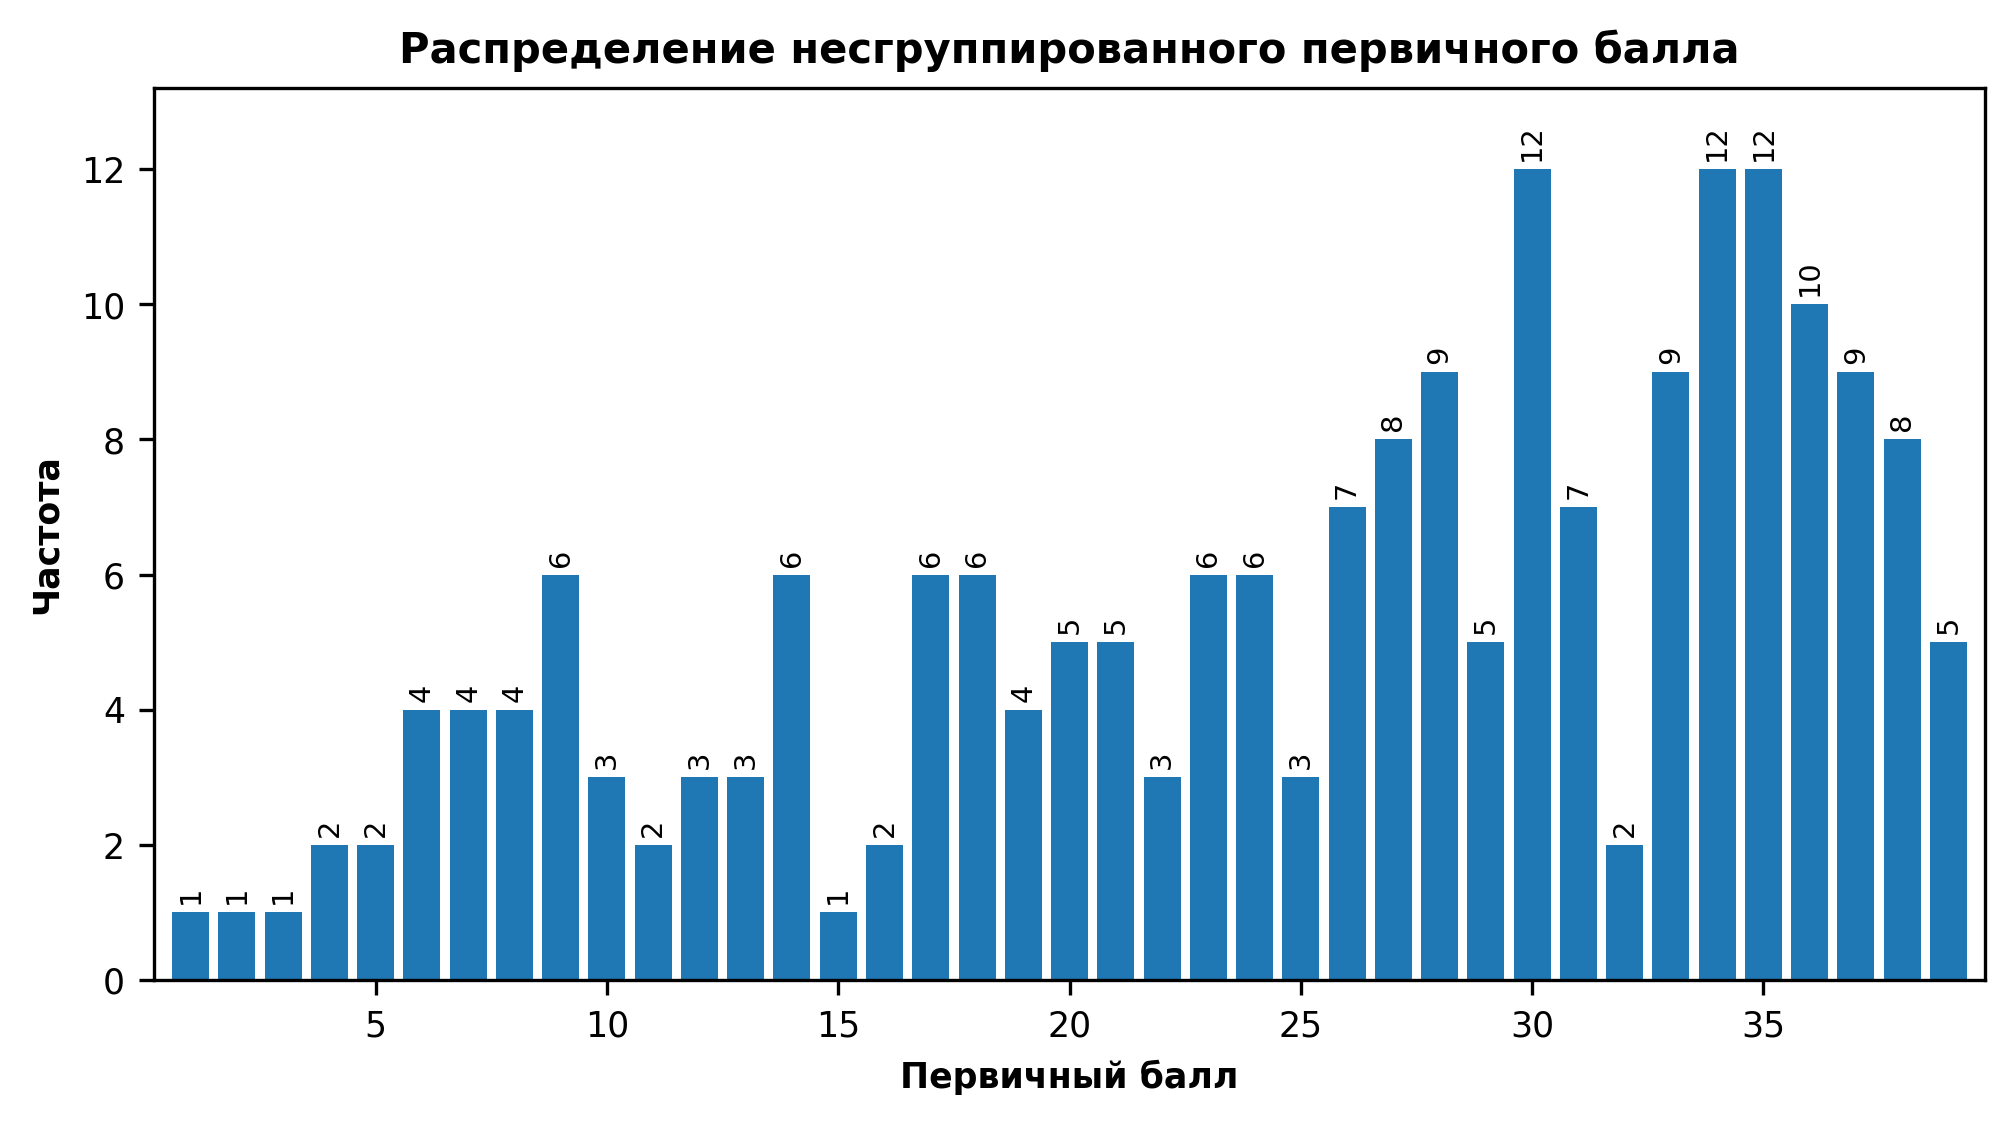

In [12]:
print("Выполнение статистического анализа")
print("Часть 1. Анализ в рамках классической теории тестов")
print("1.1. Графики распределений")

freqs = results_stats.pp_total_all.value_counts(sort=False).sort_index()

x = range(1, len(freqs) + 1)
y = freqs

fig.clear()
ax = fig.add_subplot()
# ax.set_xticks(x)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.tick_params(labelsize="small")
ax.set_xlabel("Первичный балл", fontsize="small", fontweight="bold")
ax.set_ylabel("Частота", fontsize="small", fontweight="bold")
ax.set_title(
    "Распределение несгруппированного первичного балла",
    fontsize="medium",
    fontweight="bold",
)
ax.set_xmargin(0.01)
ax.set_ymargin(0.1)
p = ax.bar(x, y, width=0.8)
bar_labels = ax.bar_label(
    p, padding=2, label_type="edge", fontsize="x-small", rotation="vertical"
)

add_content_to_doc("1.1", "image", fig)
fig

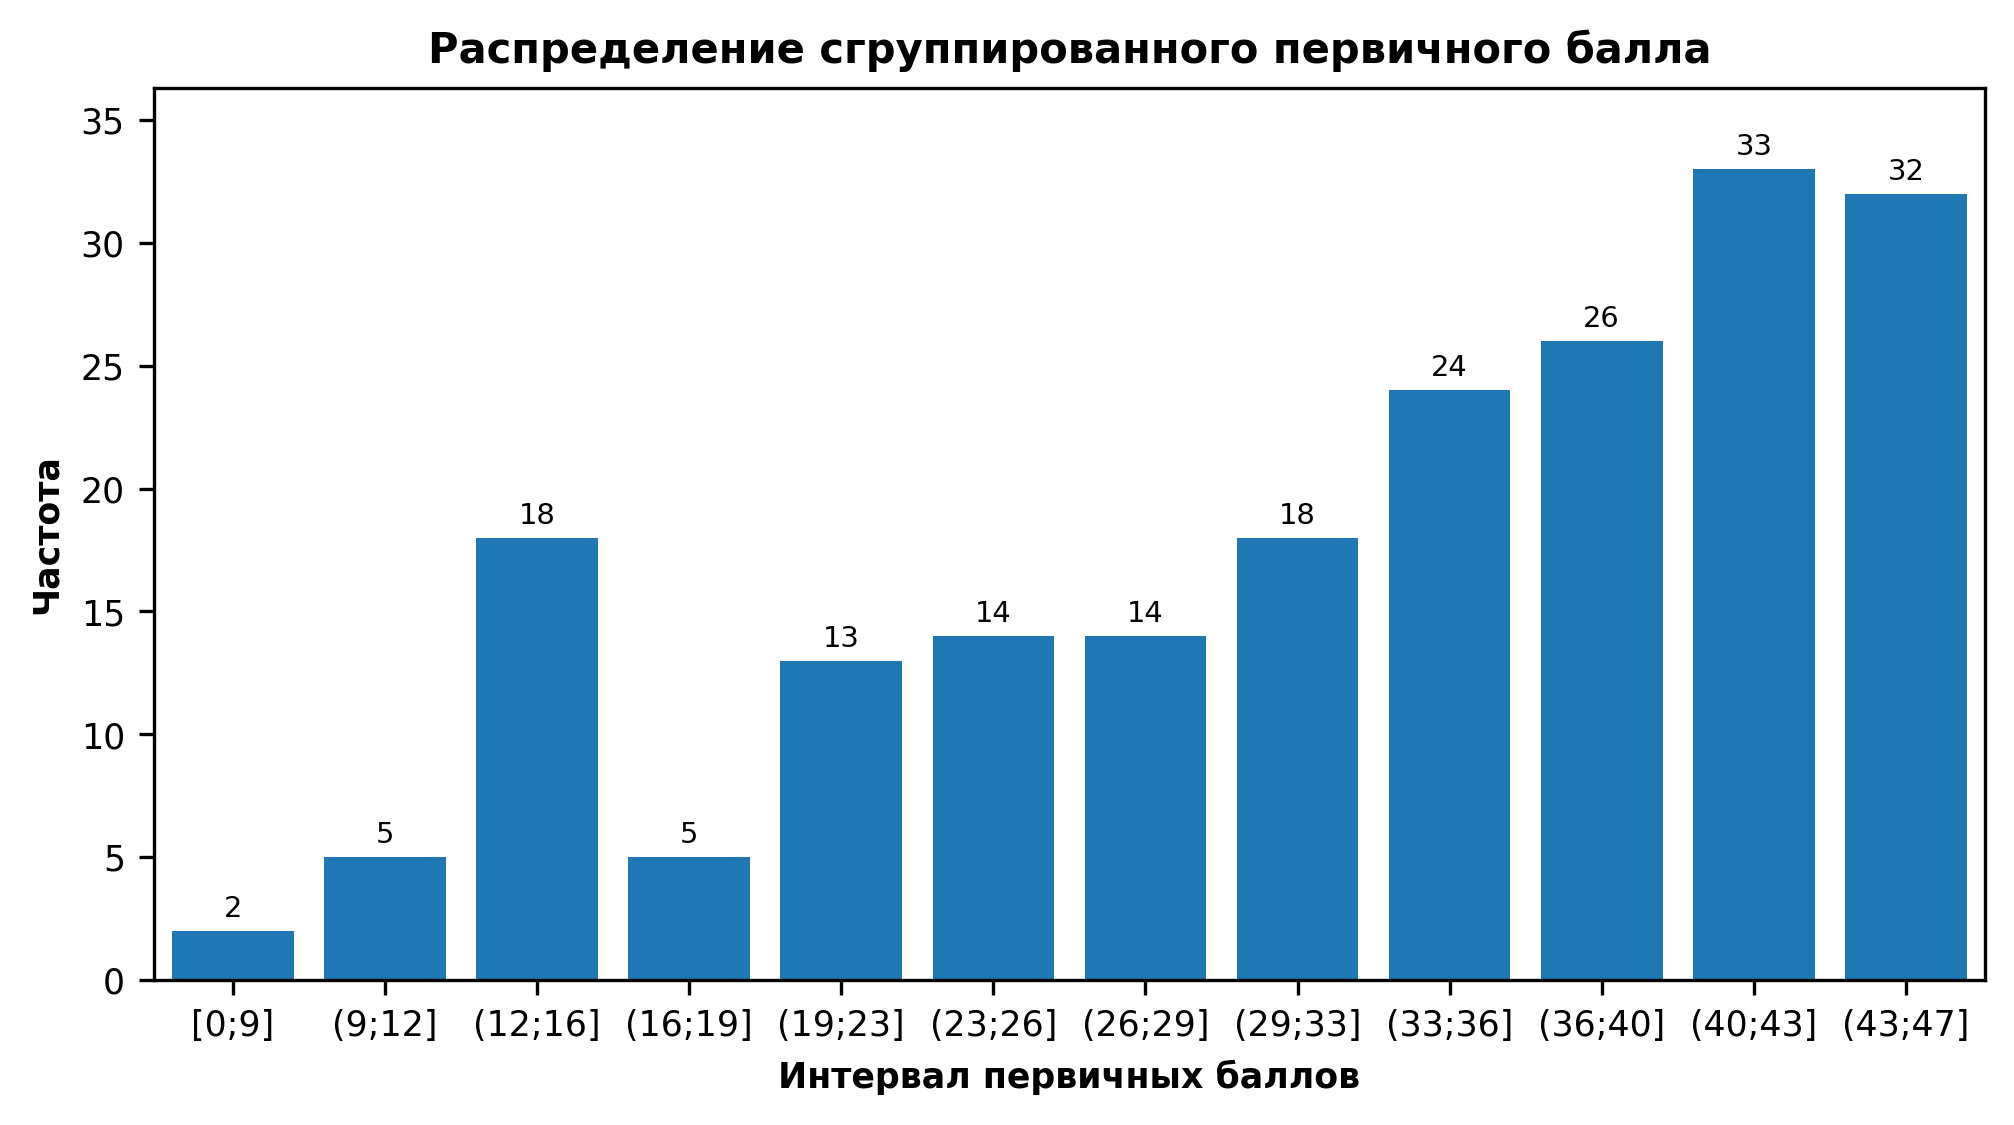

In [14]:
edges = np.linspace(
    results_stats.pp_total_all.min(), results_stats.pp_total_all.max(), bins + 1
).astype(int)
edges[0] = 0
labels = [f"[{edges[0]};{edges[1]}]"]
labels += [f"({edges[i]};{edges[i + 1]}]" for i in range(1, len(edges) - 1)]
freqs_grouped = pd.cut(
    results_stats.pp_total_all, bins=bins, labels=labels
).value_counts(sort=False)

x = labels
y = freqs_grouped

fig.clear()
ax = fig.add_subplot()
ax.set_xticks(range(len(edges) - 1), x)
ax.tick_params(labelsize="small")
ax.set_xlabel("Интервал первичных баллов", fontsize="small", fontweight="bold")
ax.set_ylabel("Частота", fontsize="small", fontweight="bold")
ax.set_title(
    "Распределение сгруппированного первичного балла",
    fontsize="medium",
    fontweight="bold",
)
ax.set_xmargin(0.01)
ax.set_ymargin(0.1)
p = ax.bar(x, y, width=0.8)
bar_labels = ax.bar_label(
    p, padding=2, label_type="edge", fontsize="x-small", rotation="horizontal"
)
add_content_to_doc("1.1", "image", fig)
fig

In [15]:
print("1.2. Проверка на нормальное распределение")
ks, p = scipy.stats.kstest(freqs, "norm")

add_content_to_doc("1.2", "text", f"Статистика критерия: {ks:.2f}.")
add_content_to_doc("1.2", "text", f"P-значение: {p:.2e}.")

if p < 0.05:
    t = "отклонена"
else:
    t = "принята"

add_content_to_doc(
    "1.2",
    "text",
    f"Гипотеза о том, что соответствующее распределение нормально, должна быть {t}.",
)

1.2. Проверка на нормальное распределение


In [16]:
print("1.3. Описательные статистики")

mode_ = float(results_stats.pp_total_all.mode()[0])
median = results_stats.pp_total_all.median()
mean = results_stats.pp_total_all.mean()
var = results_stats.pp_total_all.var()
std = results_stats.pp_total_all.std()
asymmetry = ((results_stats.pp_total_all - mean) ** 3).sum() / (
    (std ** 3) * result_count
)
kurtosis = ((results_stats.pp_total_all - mean) ** 4).sum() / (
    (std ** 4) * result_count
)

add_content_to_doc("1.3", "text", f"Кол-во наблюдений: {result_count}.")
add_content_to_doc("1.3", "text", f"Мода: {mode_:.2f}.")
add_content_to_doc("1.3", "text", f"Медиана: {median:.2f}.")
add_content_to_doc("1.3", "text", f"Среднее: {mean:.2f}.")
add_content_to_doc("1.3", "text", f"Дисперсия: {var:.2f}.")
add_content_to_doc("1.3", "text", f"Стандартное отклонение: {std:.2f}.")
add_content_to_doc("1.3", "text", f"Мера асимметрии: {asymmetry:.2f}.")
add_content_to_doc("1.3", "text", f"Мера островершинности: {kurtosis:.2f}.")

1.3. Описательные статистики


1.4. Корреяция заданий между собой


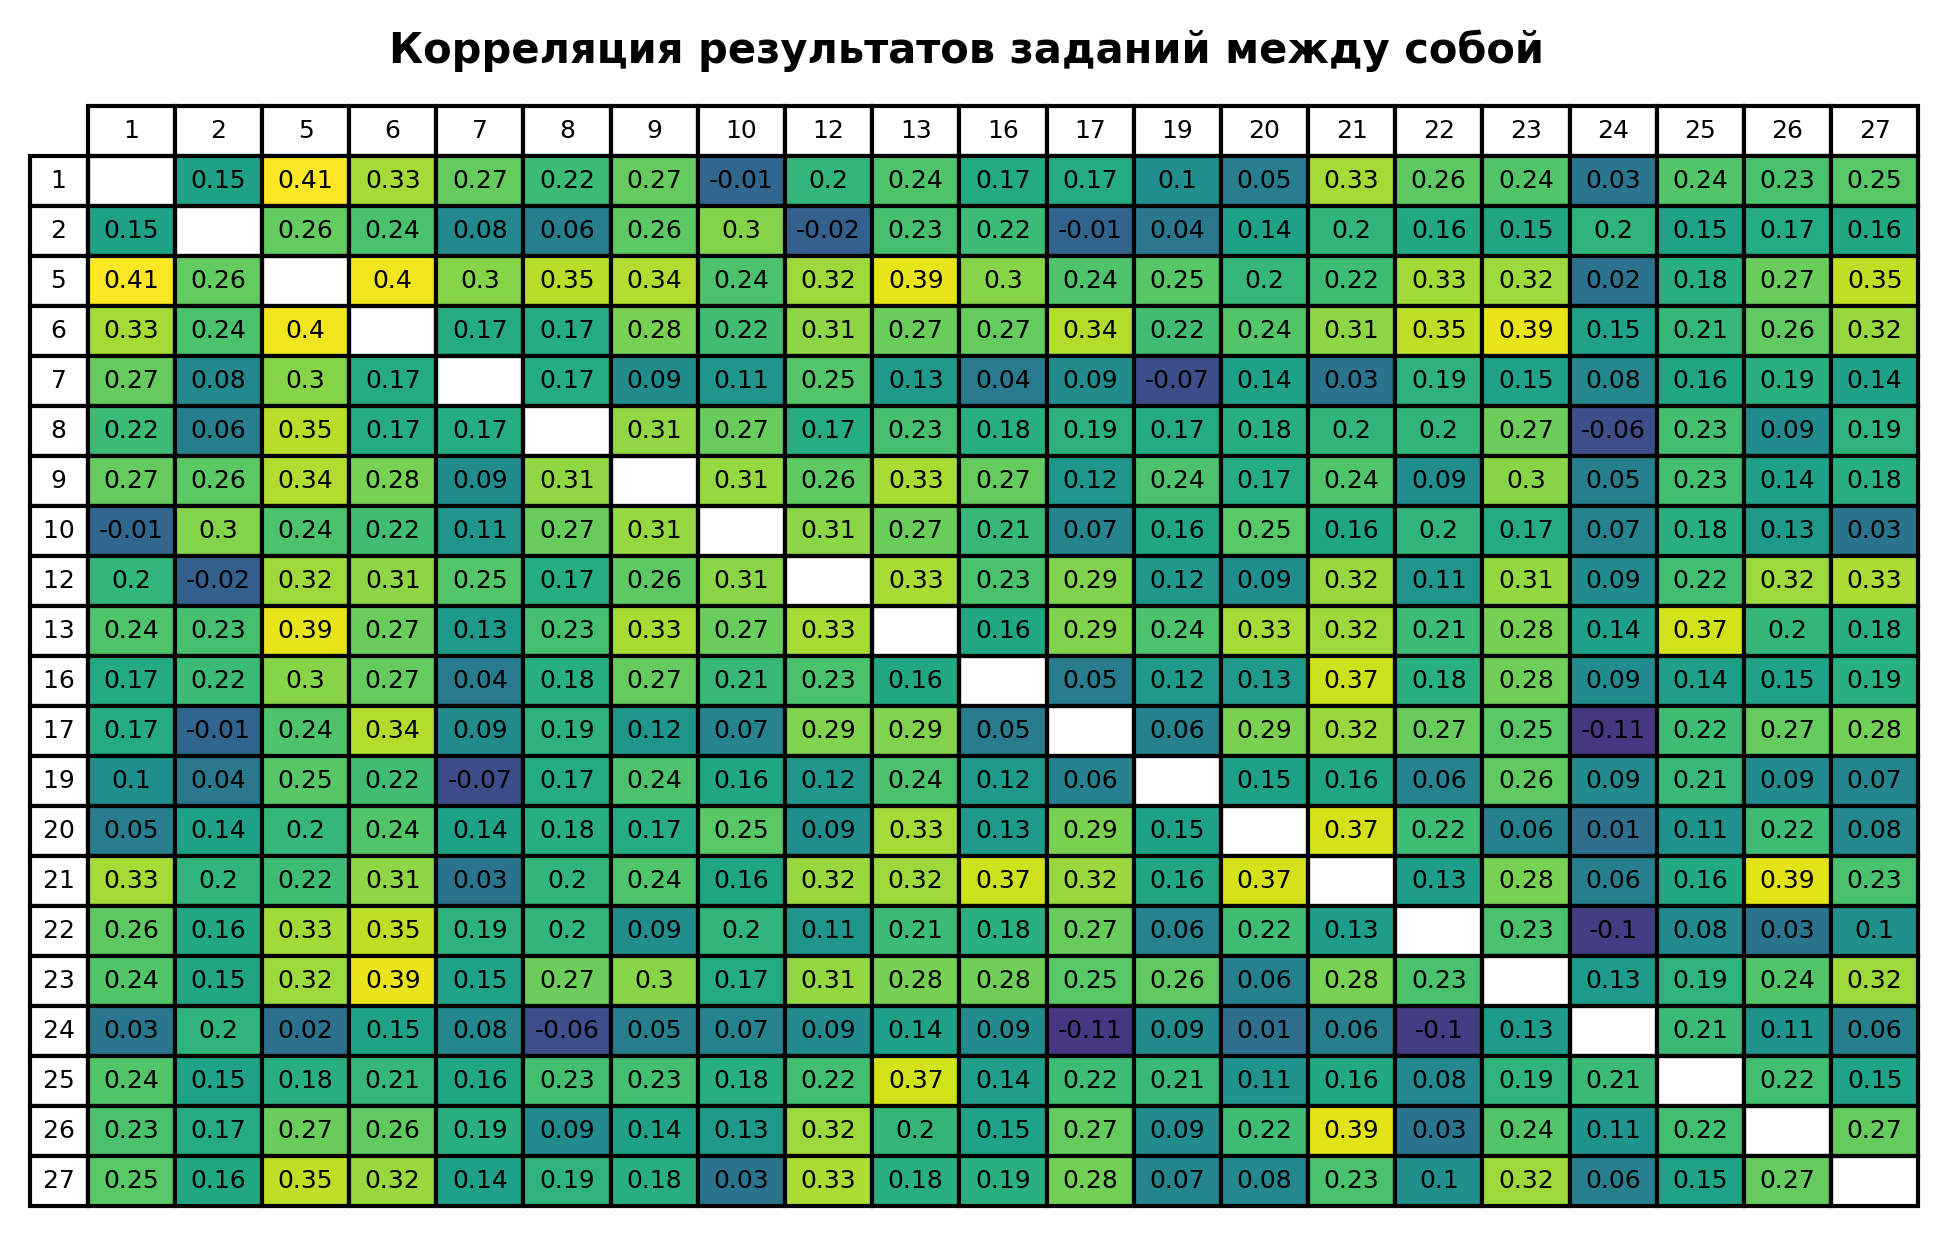

In [17]:
print("1.4. Корреляция заданий между собой")
df_correl = pd.DataFrame(
    columns=dichotomy_results.columns,
    index=dichotomy_results.columns,
    dtype=float,
)
for p in dichotomy_results.columns:
    for j in dichotomy_results.columns:
        x = dichotomy_results.loc[:, p]
        y = dichotomy_results.loc[:, j]
        if p == j:
            df_correl[p][j] = np.nan
        else:
            df_correl[p][j] = scipy.stats.pearsonr(x, y)[0]

fig.clear()
ax = fig.add_subplot()
ax.set_axis_off()
cnorm = colors.Normalize(
    vmin=df_correl.min(axis=0).min() - 0.1, vmax=df_correl.max(axis=0).max()
)
cmap = cm.get_cmap("viridis")
val_colors = cmap(cnorm(df_correl.values))
values = df_correl.values.round(2).astype(str)
for p in range(dichotomy_task_count):
    values[p][p] = ""

ax.set_title(
    "Корреляция результатов заданий между собой",
    fontsize="medium",
    fontweight="bold",
)
table = ax.table(
    cellText=values,
    rowLabels=[" " + x + " " for x in df_correl.columns],
    colLabels=df_correl.columns,
    cellColours=val_colors,
    cellLoc="center",
    rowLoc="center",
    colLoc="center",
    loc="upper left",
)
add_content_to_doc("1.4", "image", fig)
fig

1.5. Корреляция выполнения задания с суммой баллов


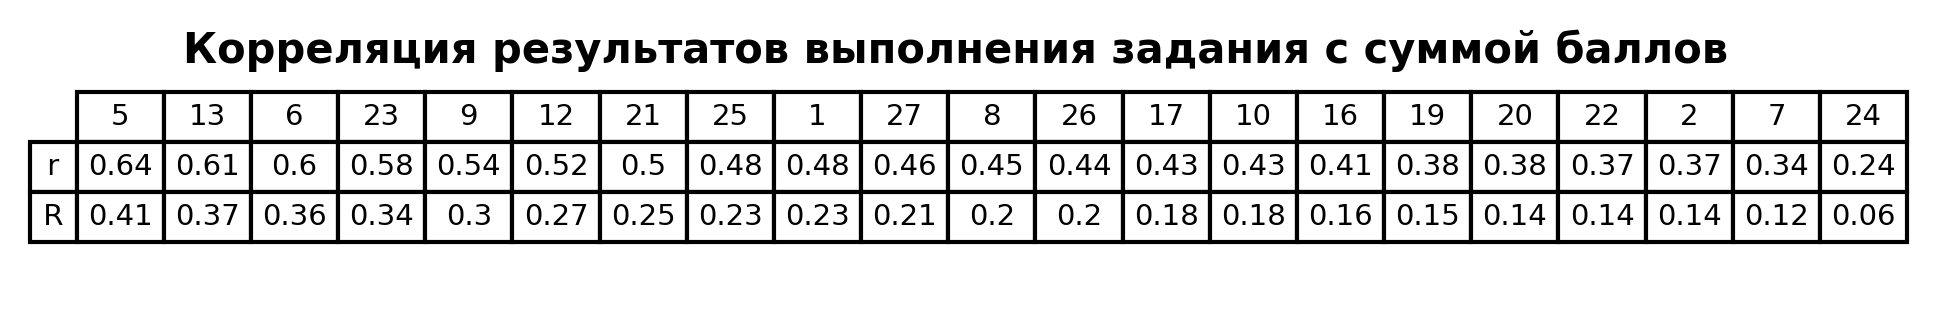

In [18]:
print("1.5. Корреляция выполнения задания с суммой баллов")
df_correl_biserial = pd.DataFrame(
    columns=["r"], index=dichotomy_results.columns
)
y = results_stats.pp_total_all
for p in dichotomy_results.columns:
    x = dichotomy_results[p]
    df_correl_biserial.loc[p, "r"] = scipy.stats.pointbiserialr(x, y)[0]
df_correl_biserial["r2"] = df_correl_biserial["r"] ** 2
df_correl_biserial.sort_values(by=["r"], inplace=True, ascending=False)

fig.clear()
axes_schema = """
AAA
...
...
...
"""
ax = fig.subplot_mosaic(axes_schema)["A"]
ax.set_axis_off()
values = df_correl_biserial.values.T.astype(float).round(2).astype(str)
ax.set_title(
    "Корреляция результатов выполнения задания с суммой баллов",
    fontsize="medium",
    fontweight="bold",
)
table = ax.table(
    cellText=values,
    rowLabels=[" r ", " R "],
    colLabels=df_correl_biserial.index,
    cellLoc="center",
    rowLoc="center",
    colLoc="center",
    loc="upper left",
)
add_content_to_doc("1.5", "image", fig)
fig

1.6. Определение трудности заданий


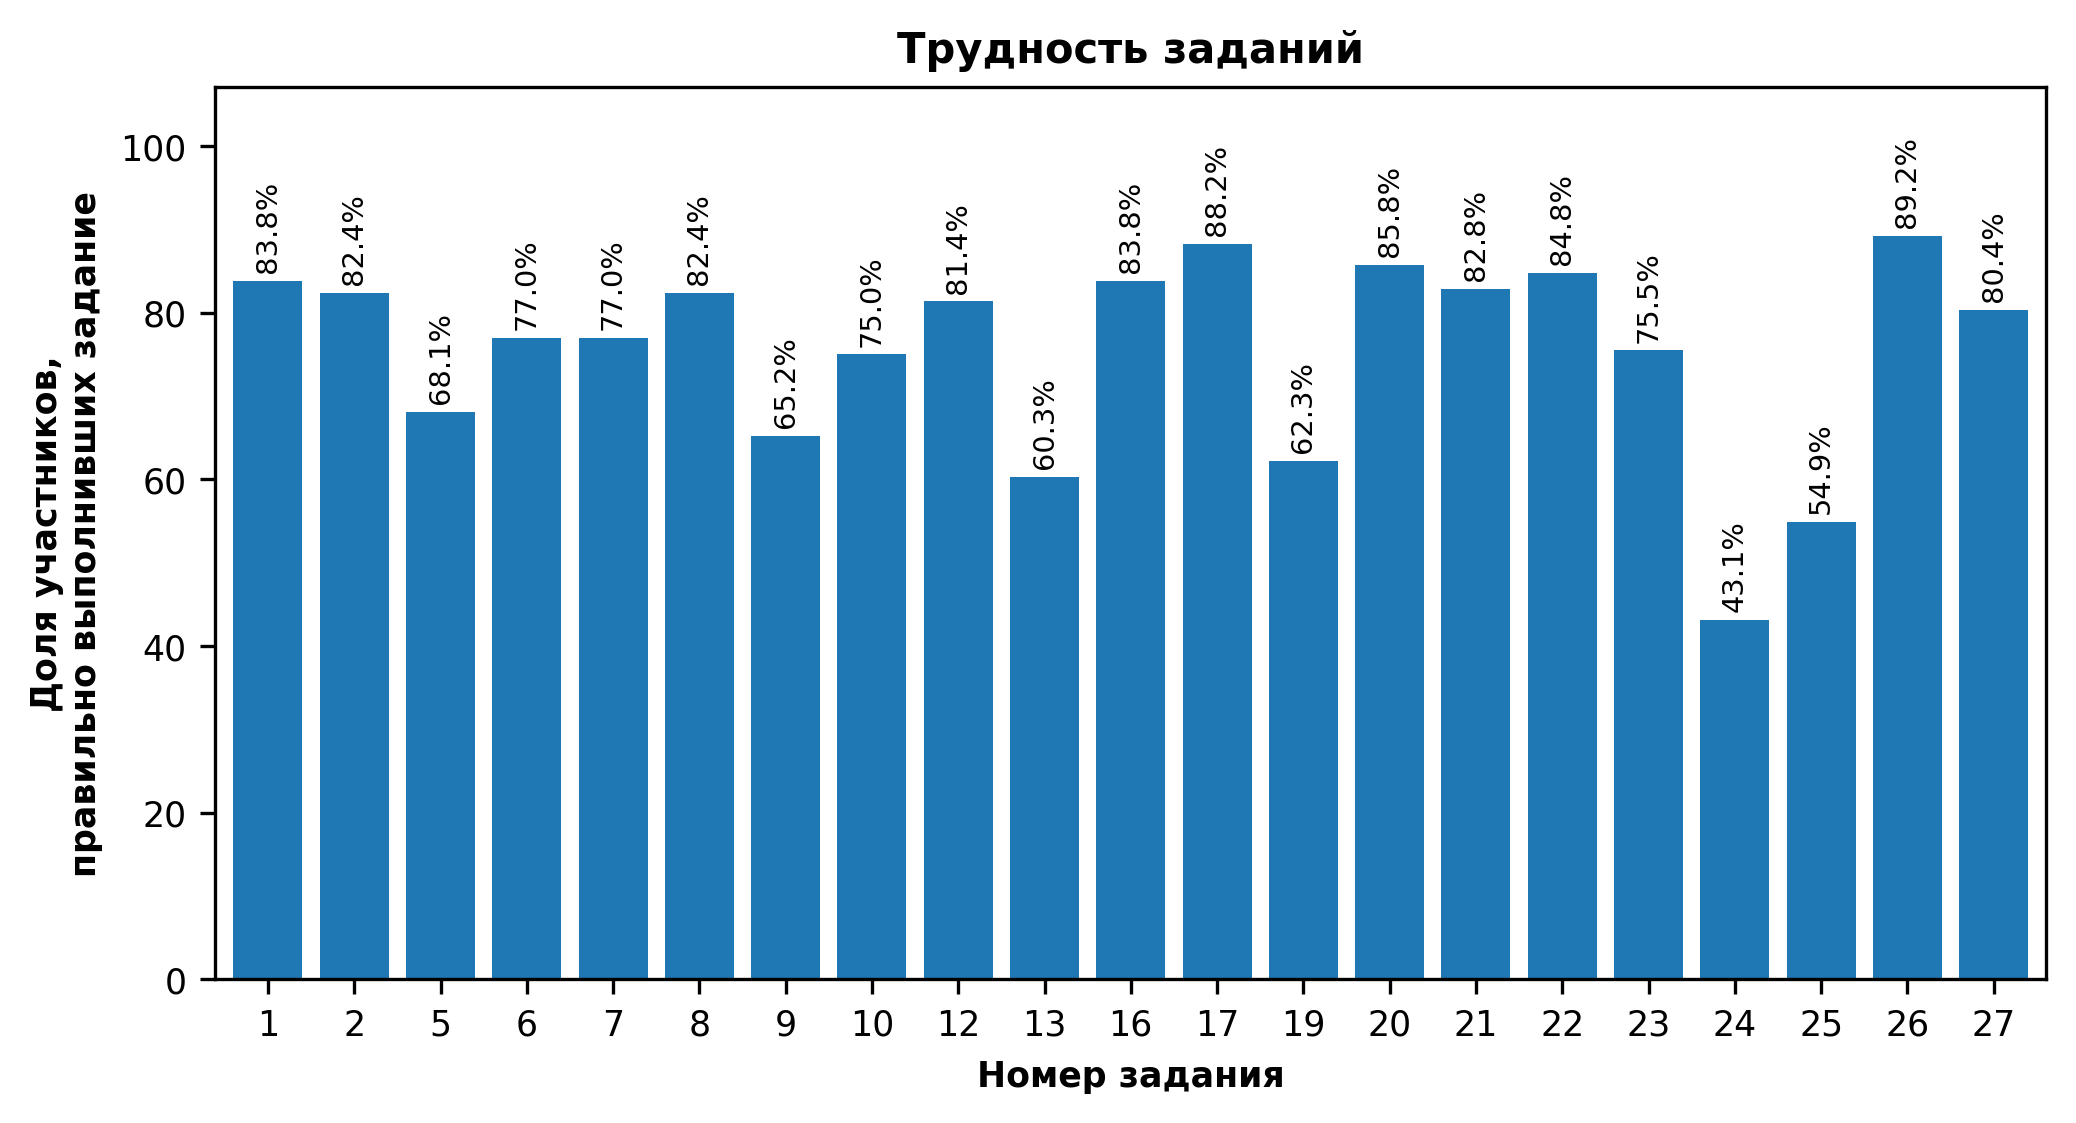

In [19]:
print("1.6. Определение трудности заданий")

x = dichotomy_results.columns
y = dichotomy_results.sum(axis=0) * 100.0 / result_count

fig.clear()
ax = fig.add_subplot()
ax.set_xticks(range(len(x)), x)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.tick_params(labelsize="small")
ax.set_xlabel("Номер задания", fontsize="small", fontweight="bold")
ax.set_ylabel(
    "Доля участников,\nправильно выполнивших задание",
    fontsize="small",
    fontweight="bold",
)
ax.set_title("Трудность заданий", fontsize="medium", fontweight="bold")
ax.set_xmargin(0.01)
ax.set_ymargin(0.2)
p = ax.bar(x, y, width=0.8)
bar_labels = ax.bar_label(
    p,
    padding=2,
    label_type="edge",
    fontsize="x-small",
    rotation="vertical",
    fmt="%0.1f%%",
)
add_content_to_doc("1.6", "image", fig)
fig

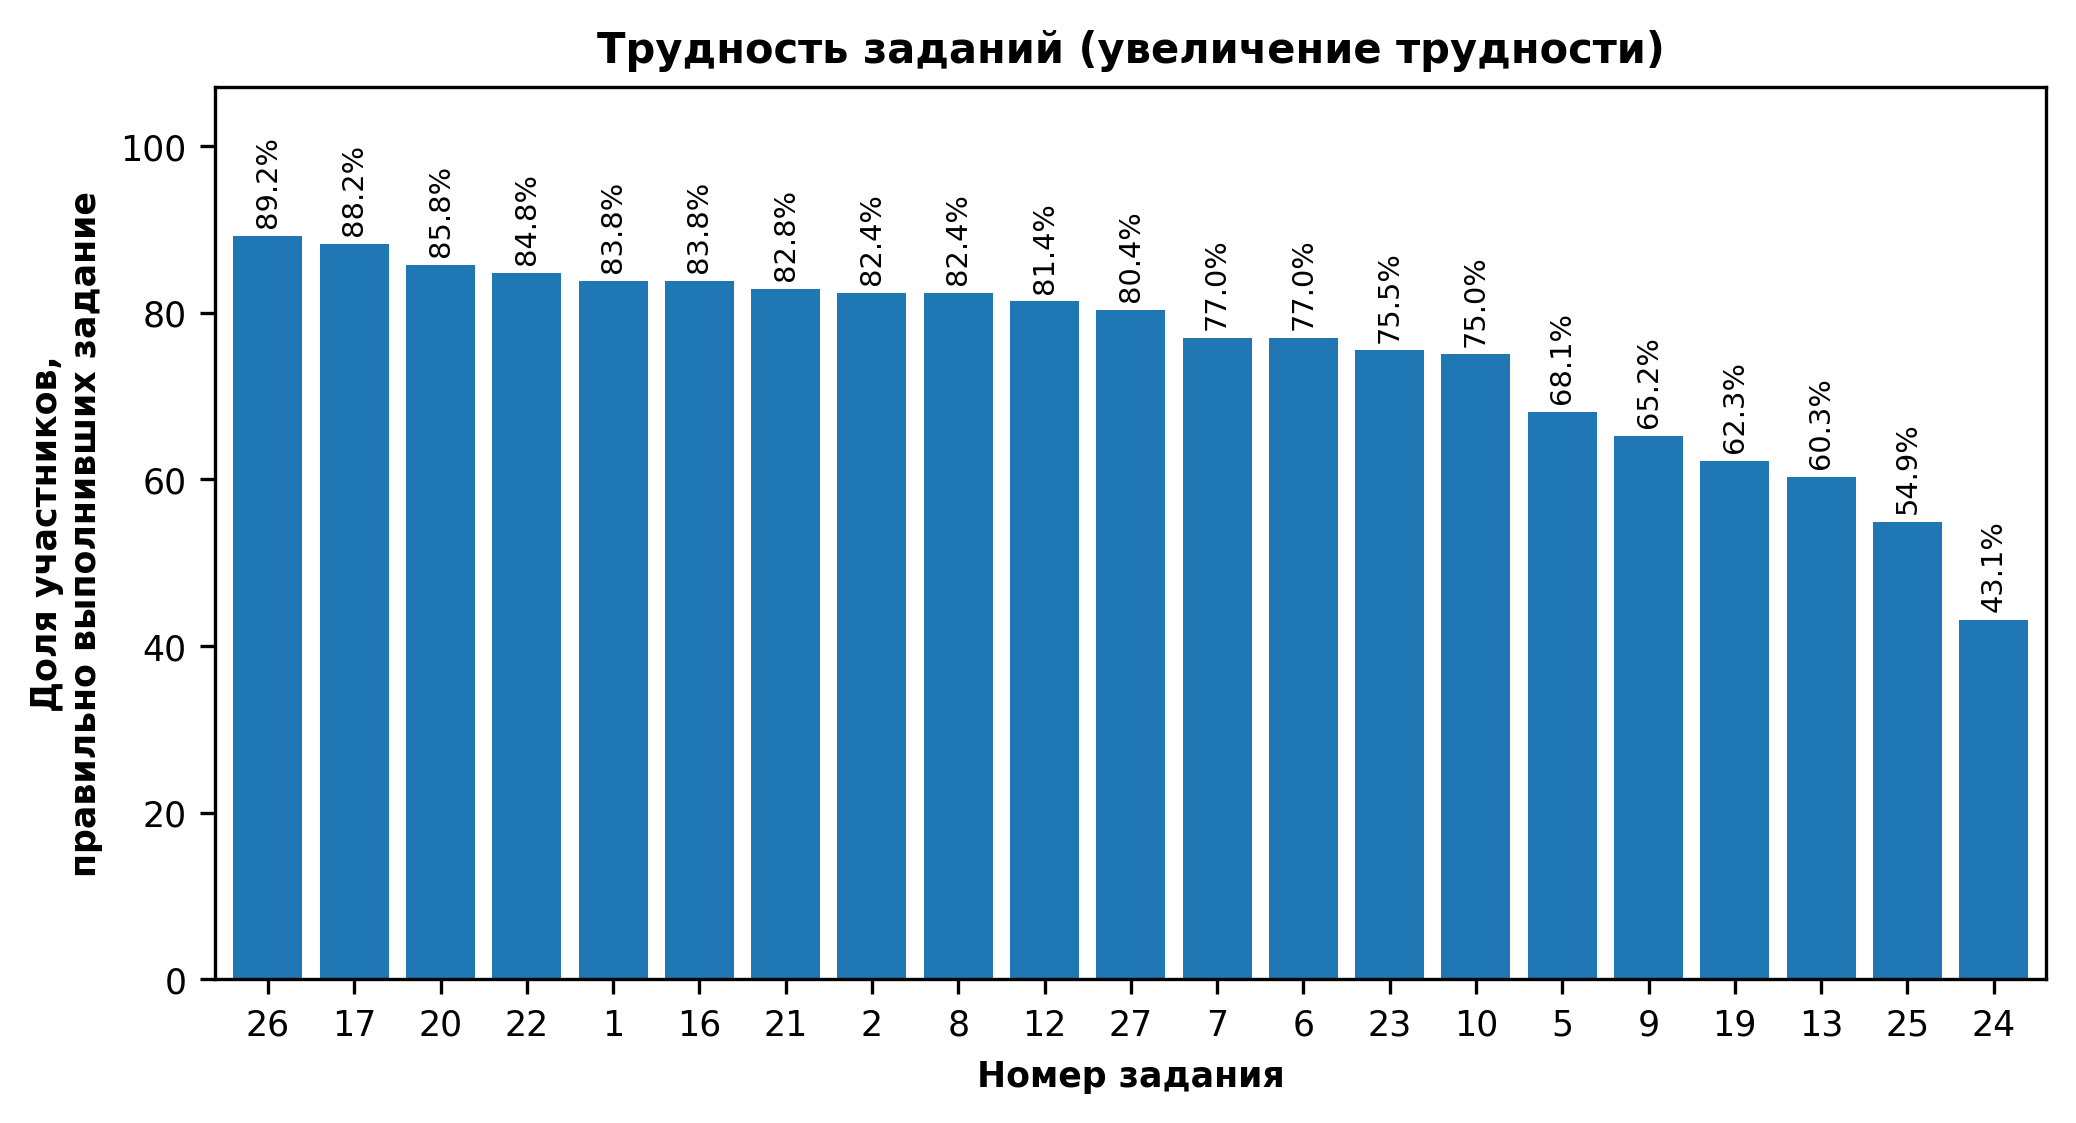

In [20]:
y.sort_values(inplace=True, ascending=False)
x = y.index

fig.clear()
ax = fig.add_subplot()
ax.set_xticks(range(len(x)), x)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.tick_params(labelsize="small")
ax.set_xlabel("Номер задания", fontsize="small", fontweight="bold")
ax.set_ylabel(
    "Доля участников,\nправильно выполнивших задание",
    fontsize="small",
    fontweight="bold",
)
ax.set_title(
    "Трудность заданий (увеличение трудности)",
    fontsize="medium",
    fontweight="bold",
)
ax.set_xmargin(0.01)
ax.set_ymargin(0.2)
p = ax.bar(x, y, width=0.8)
bar_labels = ax.bar_label(
    p,
    padding=2,
    label_type="edge",
    fontsize="x-small",
    rotation="vertical",
    fmt="%0.1f%%",
)
add_content_to_doc("1.6", "image", fig)
fig

1.7. Дискриминативность заданий


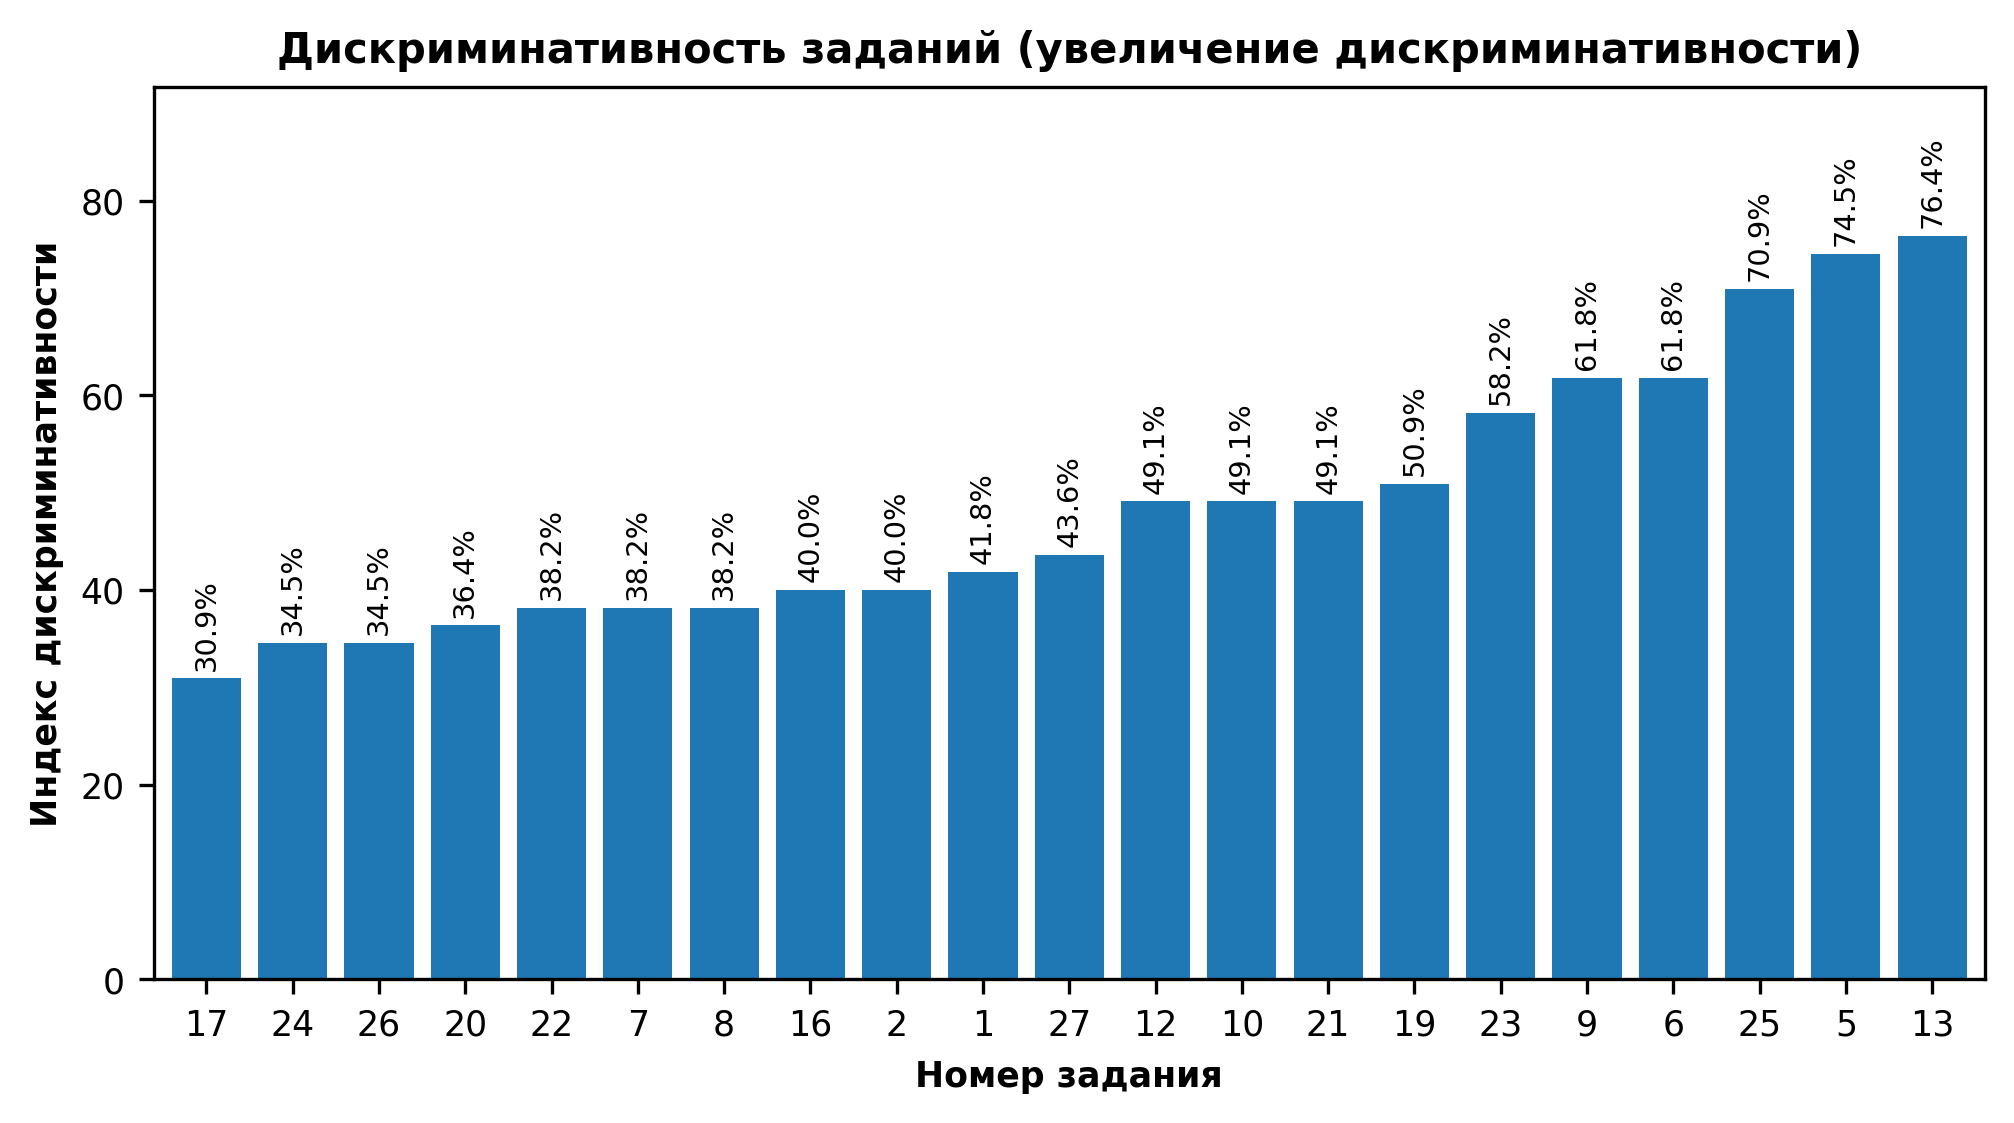

In [21]:
print("1.7. Дискриминативность заданий")
positions = results_stats.sort_values(
    by=["pp_total_dichotomy"], ascending=False
).index

sorted_dichtomy_results = dichotomy_results.iloc[positions, :]
percent = 0.27
count = int(result_count * percent)
right_answers_percent_best = (
    sorted_dichtomy_results.iloc[:count, :].sum(axis=0) / count
)
right_answers_percent_worst = (
    sorted_dichtomy_results.iloc[-count:, :].sum(axis=0) / count
)
discrim_indexes = (
    right_answers_percent_best - right_answers_percent_worst
) * 100

discrim_indexes.sort_values(ascending=True, inplace=True)

y = discrim_indexes
x = discrim_indexes.index

fig.clear()
ax = fig.add_subplot()
ax.set_xticks(range(len(x)), x)
ax.tick_params(labelsize="small")
ax.set_xlabel("Номер задания", fontsize="small", fontweight="bold")
ax.set_ylabel("Индекс дискриминативности", fontsize="small", fontweight="bold")
ax.set_title(
    "Дискриминативность заданий (увеличение дискриминативности)",
    fontsize="medium",
    fontweight="bold",
)
ax.set_xmargin(0.01)
ax.set_ymargin(0.2)
p = ax.bar(x, y, width=0.8)
bar_labels = ax.bar_label(
    p,
    padding=2,
    label_type="edge",
    fontsize="x-small",
    rotation="vertical",
    fmt="%0.1f%%",
)
add_content_to_doc("1.7", "image", fig)
fig

In [22]:
print("1.8. Коэффициент надежности")
def calc_split_reliability(x, y):
    r = scipy.stats.pearsonr(x, y)[0]
    return 2.0 * r / (1.0 + r)


def cronbach_alpha(df):
    df_corr = df.corr()
    N = df.shape[1]
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i + 1 :].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha



total_tasks = all_task_count  # Без суммы баллов
even_tasks = all_results.iloc[:, list(range(0, total_tasks, 2))]
odd_tasks = all_results.iloc[:, list(range(1, total_tasks, 2))]
reliability = calc_split_reliability(
    even_tasks.sum(axis=1), odd_tasks.sum(axis=1)
)
alpha = cronbach_alpha(all_results)
add_content_to_doc(
    "1.8",
    "text",
    f"Коэффициент надежности методом расщепления: {reliability:.2f}.",
)
add_content_to_doc("1.8", "text", f"Коэффициент альфа (Кронбах): {alpha:.2f}.")

1.8. Коэффициент надежности


In [23]:
print("1.9. Стандартная ошибка и погрешность")
error_std = std * np.sqrt(1 - reliability)
delta = 1.96 * error_std
add_content_to_doc(
    "1.9", "text", f"Стандартная ошибка измерения: {error_std:.2f}."
)
add_content_to_doc(
    "1.9", "text", f"Погрешность (α = 0.05): ±{delta:.2f} (в баллах)."
)

1.9. Стандартная ошибка и погрешность


# Stat. analysis. Part 2

In [24]:
print("Часть 2. Анализ в рамках современной теории тестов")
print("Выполнение расчета параметров модели (может занять несколько минут)")
estimates = pcm_mml(all_results.T.values)
difficulty = estimates["Difficulty"]
discrimination = pd.Series(estimates["Discrimination"])
print("Праметров модели расчитаны")

Часть 2. Анализ в рамках современной теории тестов


In [25]:
print("2.1. Графики характеристических кривых заданий теста")
# all_probs, dichotomy_probs, not_dichtotomy_probs
# all_probs = [task1, task2, ...]
# all_probs[task] = ['right':[...], 'wrong':[...]
# all_probs[task]['right'] = [[points1], [points2]]


def calc_probs(results, abilities, difficulty):
    task_count = results.shape[1]
    max_points_in_task = (~np.isnan(difficulty)).sum(axis=1)
    probs = [
        {
            "right": [[] for j in range(max_points_in_task[i])],
            "0": None,
        }
        for i in range(task_count)
    ]
    cur_probs = np.zeros((irt_points), dtype=float)
    for task in range(task_count):
        probs[task]["0"] = np.ones((irt_points), dtype=float)
        for target_point in rangei(0, max_points_in_task[task] - 1):
            for i in range(irt_points):
                sum_diffs = 0
                for k in rangei(0, target_point):
                    sum_diffs += abilities[i] - difficulty[task][k]
                p = np.exp(sum_diffs)

                sum_exps = 0
                for j in rangei(0, max_points_in_task[task] - 1):
                    sum_diffs = 0
                    for k in rangei(0, j):
                        sum_diffs += abilities[i] - difficulty[task][k]
                    sum_exps += np.exp(sum_diffs)
                q = 1 + sum_exps
                cur_probs[i] = p / q
            probs[task]["right"][target_point] = cur_probs.copy()
            probs[task]["0"] -= cur_probs
    return probs, max_points_in_task


abilities = np.linspace(irt_abilities_min, irt_abilities_max, irt_points)
all_probs, max_points_in_task = calc_probs(all_results, abilities, difficulty)

2.1. Графики характеристических кривых заданий теста


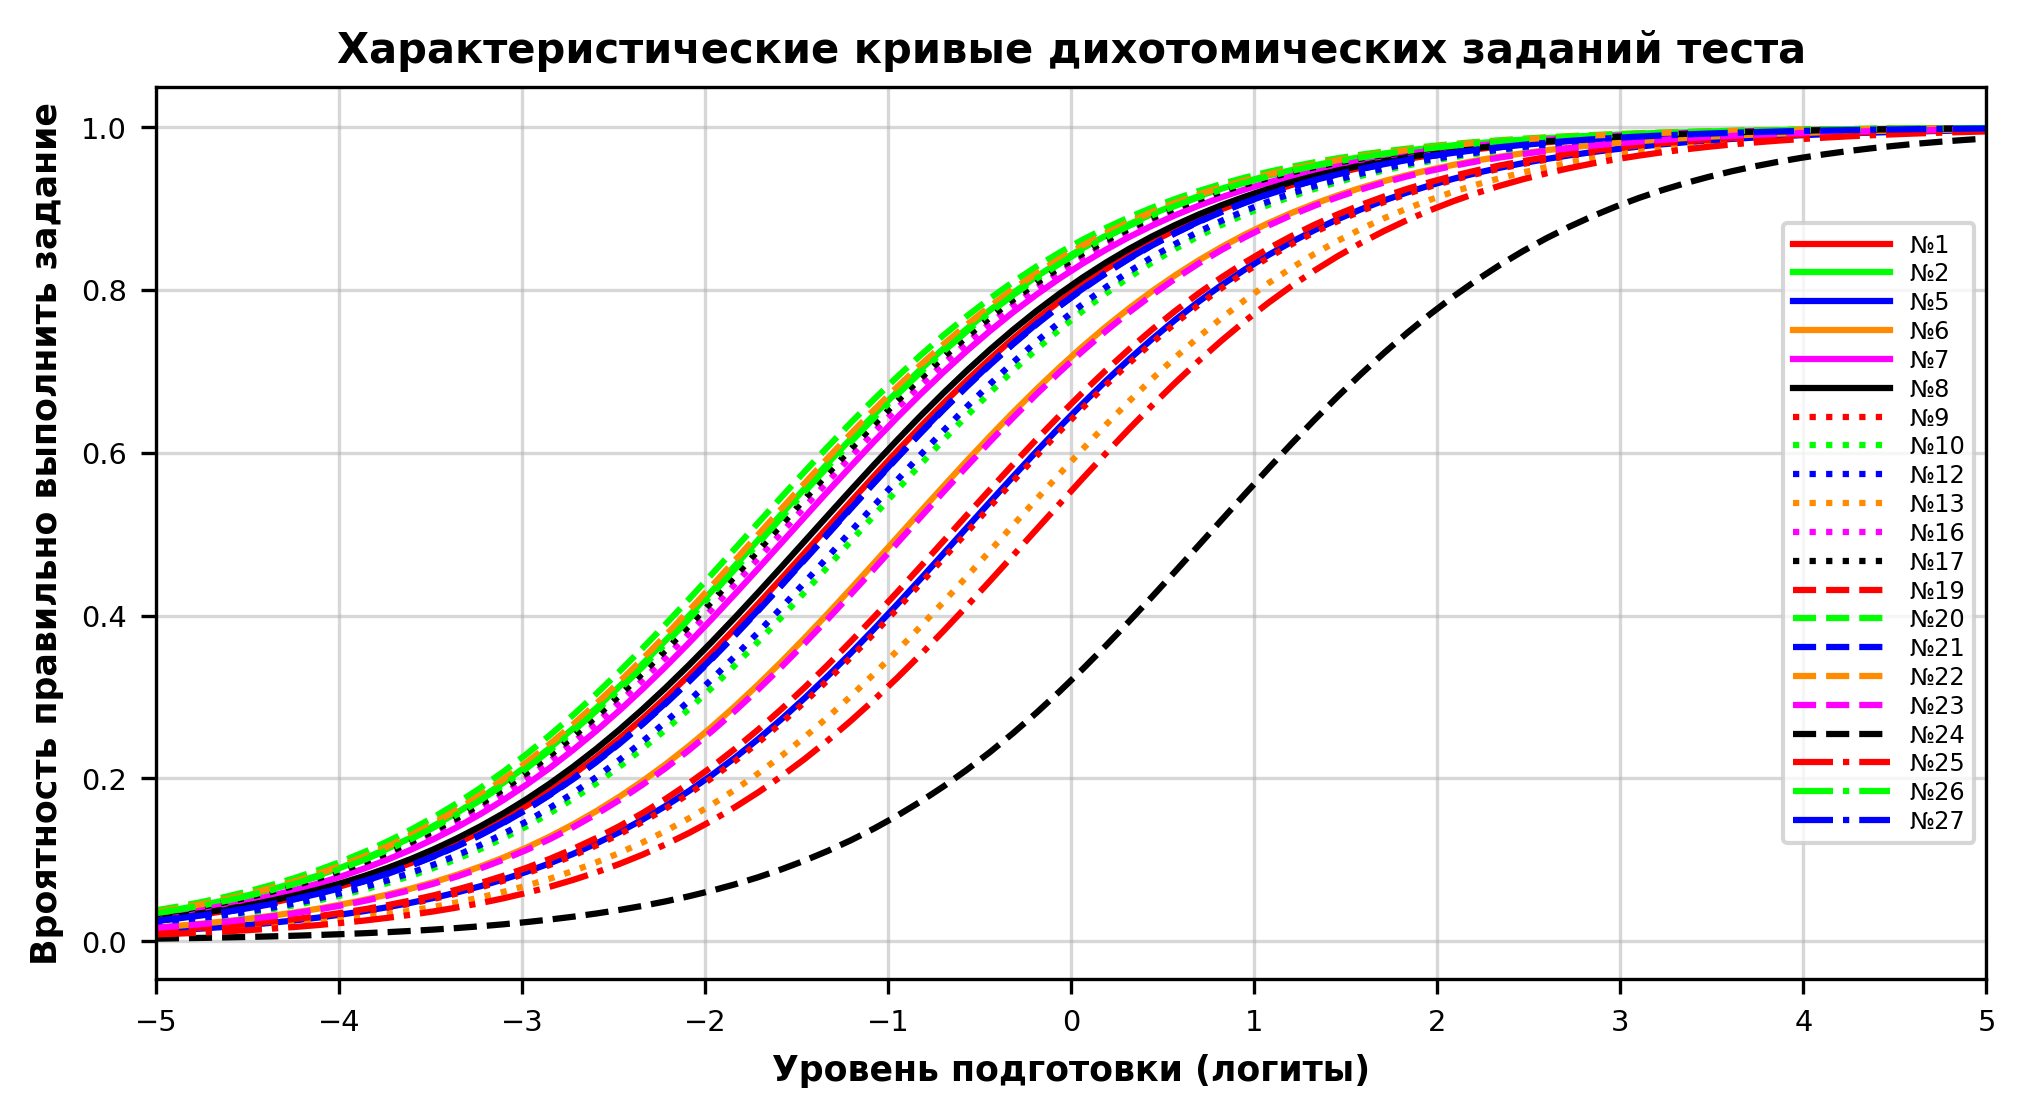

In [26]:
colors_ = ["red", "lime", "blue", "darkorange", "magenta", "black"]
line_styles = ["solid", "dotted", "dashed", "dashdot", (0, (3, 1, 1, 1, 1, 1))]
cycler1 = cycler.cycler(linestyle=line_styles) * cycler.cycler(color=colors_)
linewidht = 1.5
markersize = 0.5
fig.clear()
ax = fig.add_subplot()
ax.set_prop_cycle(cycler1)
x = abilities
for task_min in range(all_task_count):
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xlim(-5, 5)
    ax.tick_params(labelsize="x-small")
    if max_points_in_task[task_min] == 1:
        y = all_probs[task_min]["right"][0]
        ax.plot(
            x, y, label=f"№{task_min + 1}", linewidth=linewidht, markersize=3
        )

ax.set_title(
    "Характеристические кривые дихотомических заданий теста",
    fontsize="medium",
    fontweight="bold",
)
ax.set_xlabel(
    "Уровень подготовки (логиты)", fontsize="small", fontweight="bold"
)
ax.set_ylabel(
    "Вроятность правильно выполнить задание",
    fontsize="small",
    fontweight="bold",
)
ax.legend(
    fontsize="xx-small", loc="center right", labelspacing=0.2, handlelength=4
)
ax.grid(True, alpha=0.5)
add_content_to_doc("2.1", "image", fig)
fig

In [27]:
add_content_to_doc(
    "2.1",
    "text",
    "Далее представлены характеристические кривые для всех заданий теста. " +
    "На графиках отмечены вероятности получения указанного количества баллов за задание. "+
    "Абсцисса - уровень подготовки в логитах. Ордината - искомая вероятность.",
)

linewidht = 1.0
for task_min in range(0, all_task_count, 3):
    fig.clear()
    axes_schema = """
    012
    ...
    ...
    """
    axs = fig.subplot_mosaic(axes_schema)
    for k in axs.keys():
        ax = axs[k]
        ax.set_prop_cycle(cycler1)
        ax.margins(x=0.01, y=0.04)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
        task_cur = task_min + int(k)
        if task_cur >= all_task_count:
            if k == "1":
                axs["1"].set_axis_off()
                axs["2"].set_axis_off()
            if k == "2":
                axs["2"].set_axis_off()
            break
        y = all_probs[task_cur]["0"]
        ax.plot(x, y, label="0", linewidth=linewidht)

        for p in range(max_points_in_task[task_cur]):
            y = all_probs[task_cur]["right"][p]
            ax.plot(x, y, label=str(p + 1), linewidth=linewidht)

        ax.set_title(task_cur + 1, fontsize="medium", fontweight="bold")
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.tick_params(labelsize="x-small")
        ax.legend(fontsize="xx-small", loc="center right", labelspacing=0.2)
        if max_points_in_task[task_cur] == 1:
            x1, x2 = (difficulty[task_cur][0], difficulty[task_cur][0])
            y1, y2 = (-0.01, 0.5)
            ax.plot(
                (x1, x2),
                (y1, y2),
                "--o",
                linewidth=linewidht,
                markersize=2,
                markevery=300,
            )
            ax.text(x1, y1, f"  {x1:.2n}", fontsize="x-small")

    add_content_to_doc("2.1", "image", fig)
    fig

2.2. График информационной функции теста


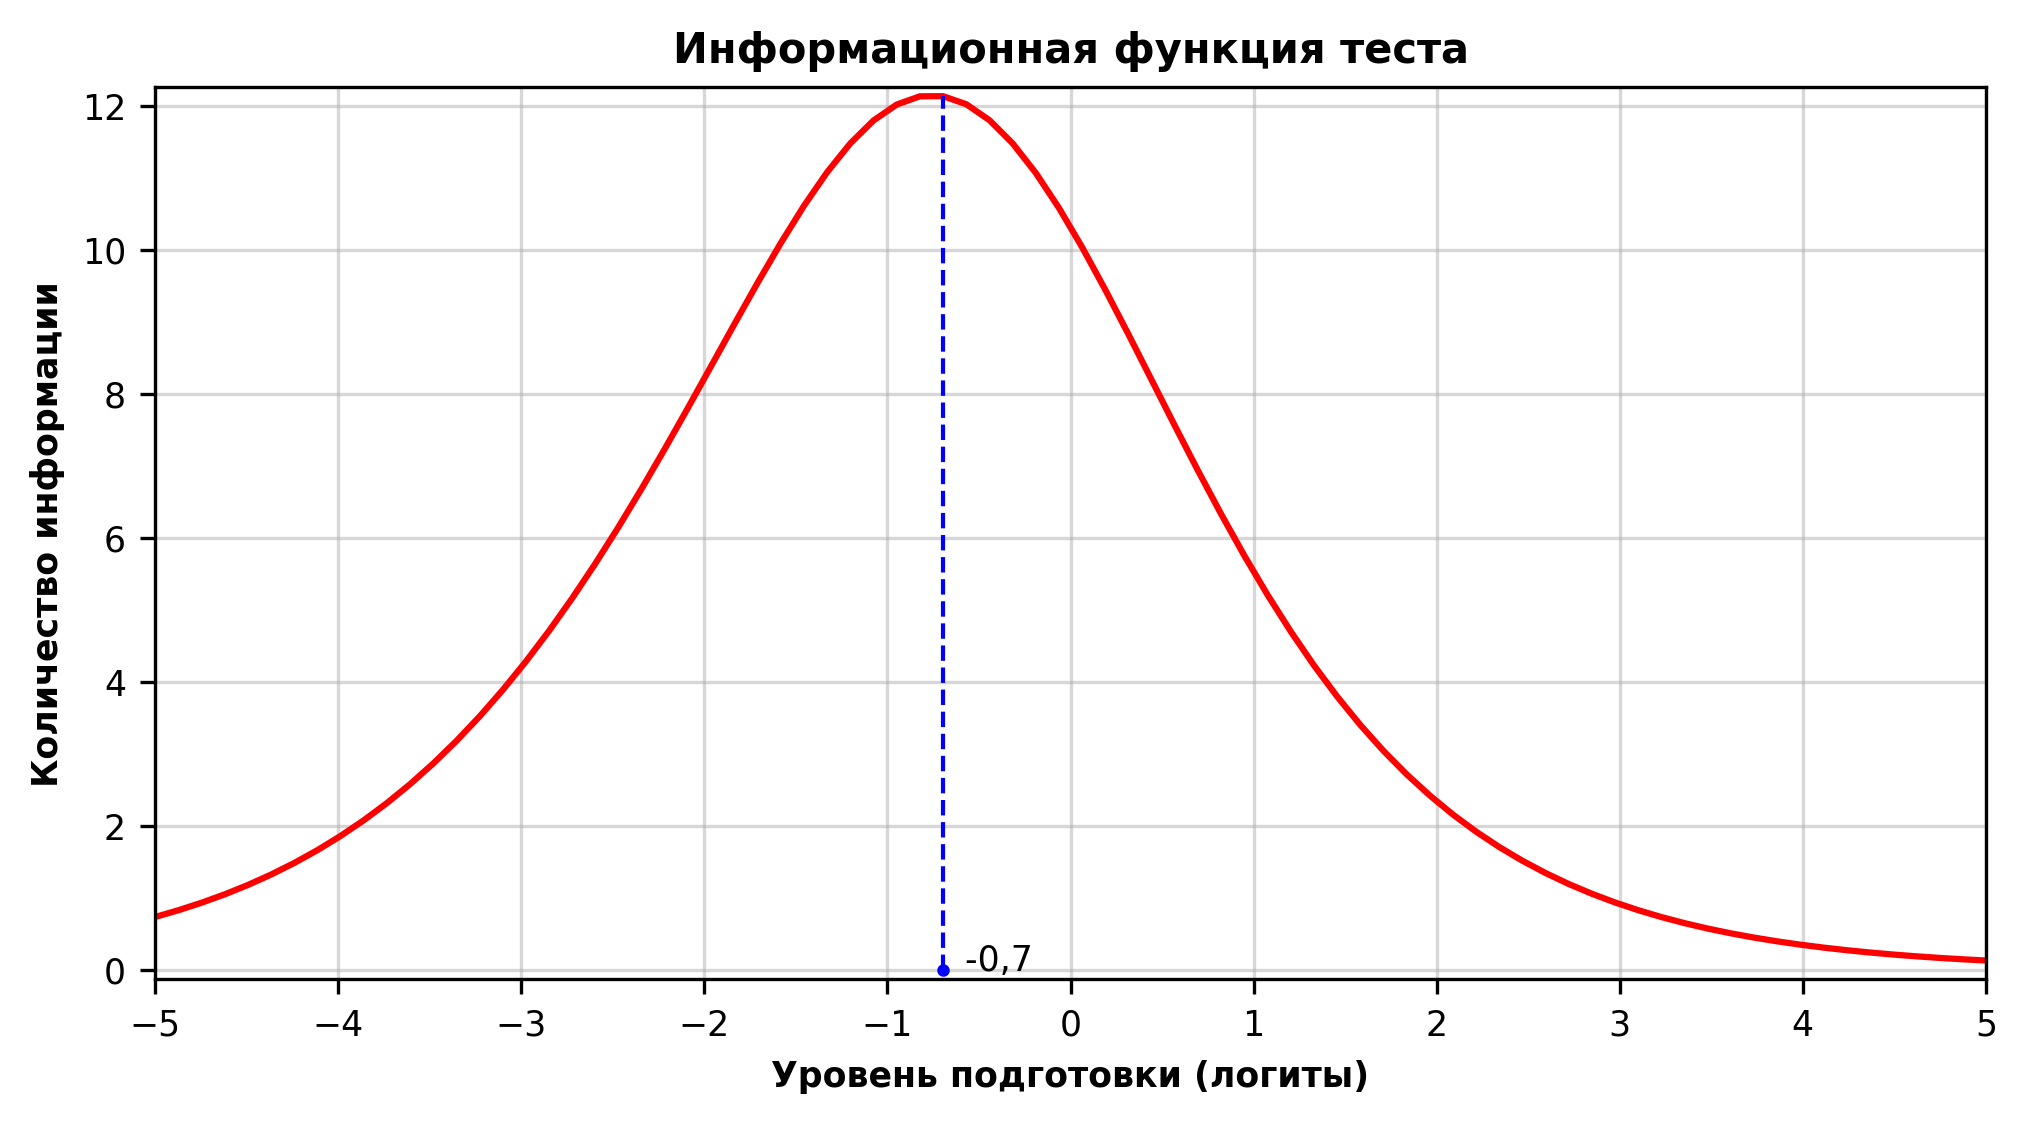

In [28]:
print("2.2. График информационной функции теста")
irt_info = pd.DataFrame()
irt_info["se"] = np.zeros((irt_points))
for a in range(len(abilities)):
    number_sum = 0
    for task in range(all_task_count):
        sum1 = 0
        for l in rangei(1, max_points_in_task[task]):
            sum1 += (l ** 2) * all_probs[task]["right"][l - 1][a]
        sum2 = 0
        for l in rangei(1, max_points_in_task[task]):
            sum2 += l * all_probs[task]["right"][l - 1][a]
        number_sum += sum1 - sum2 ** 2
    irt_info.se[a] = 1 / np.sqrt(number_sum)

irt_info["info"] = 1.0 / (irt_info["se"] ** 2)

x_max = np.argmax(irt_info["info"])
a_max = abilities[x_max]

x = abilities
y = irt_info["info"]

fig.clear()
ax = fig.add_subplot()
# ax.set_xticks(x)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.tick_params(labelsize="small")
ax.set_xlabel(
    "Уровень подготовки (логиты)", fontsize="small", fontweight="bold"
)
ax.set_ylabel("Количество информации", fontsize="small", fontweight="bold")
ax.set_title(
    "Информационная функция теста",
    fontsize="medium",
    fontweight="bold",
)
ax.margins(x=0, y=0.01)
ax.plot(x, y, "r")
x1, x2 = (a_max, a_max)
y1, y2 = (-0.01, irt_info["info"][x_max])
ax.plot(
    (x1, x2), (y1, y2), "b--o", linewidth=linewidht, markersize=2, markevery=300
)
ax.text(x1, y1, f"  {float(x1):.2n}", fontsize="small")
ax.grid(True, alpha=0.5)
add_content_to_doc("2.2", "image", fig)
fig

2.3. Трудность заданий


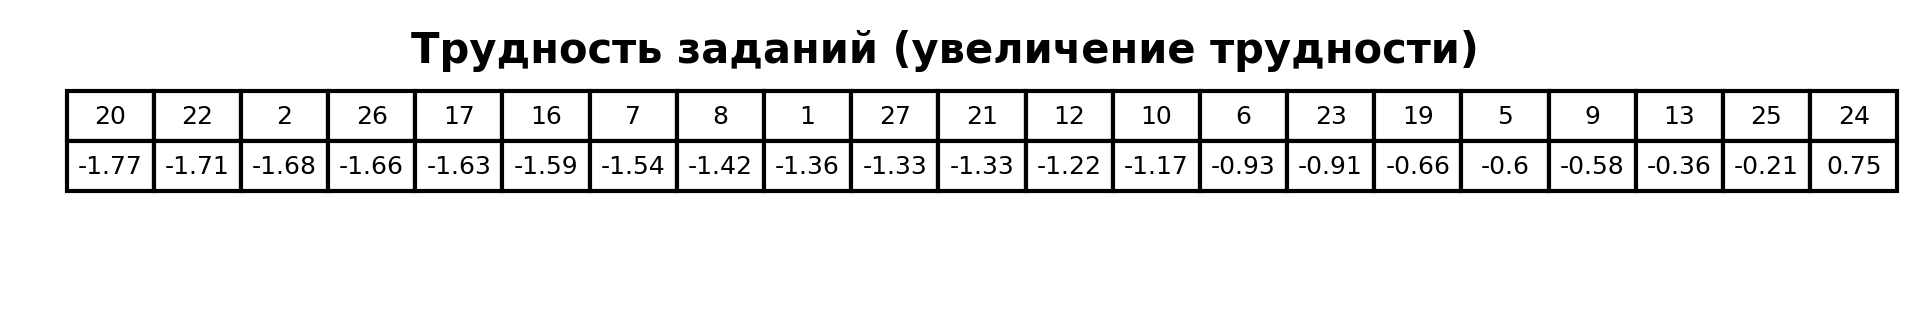

In [29]:
print("2.3. Трудность заданий")

data = []
for i in range(all_task_count):
    if max_points_in_task[i] == 1:
        data.append(difficulty[i][0])
data = pd.Series(data, index=dichotomy_results.columns)
data.sort_values(inplace=True)
fig.clear()
axes_schema = """
AAA
...
...
...
"""
ax = fig.subplot_mosaic(axes_schema)["A"]
ax.set_axis_off()
values = data.values.astype(float).round(2).astype(str)
for i in range(len(values)):
    values[i] = values[i]
ax.set_title(
    "Трудность заданий (увеличение трудности)",
    fontsize="medium",
    fontweight="bold",
)
table = ax.table(
    cellText=np.atleast_2d(values),
    # rowLabels=[" Трудн. "],
    colLabels=data.index,
    cellLoc="center",
    rowLoc="center",
    colLoc="center",
    loc="upper left",
)
add_content_to_doc("2.3", "image", fig)
fig

2.4. Дискриминативность заданий


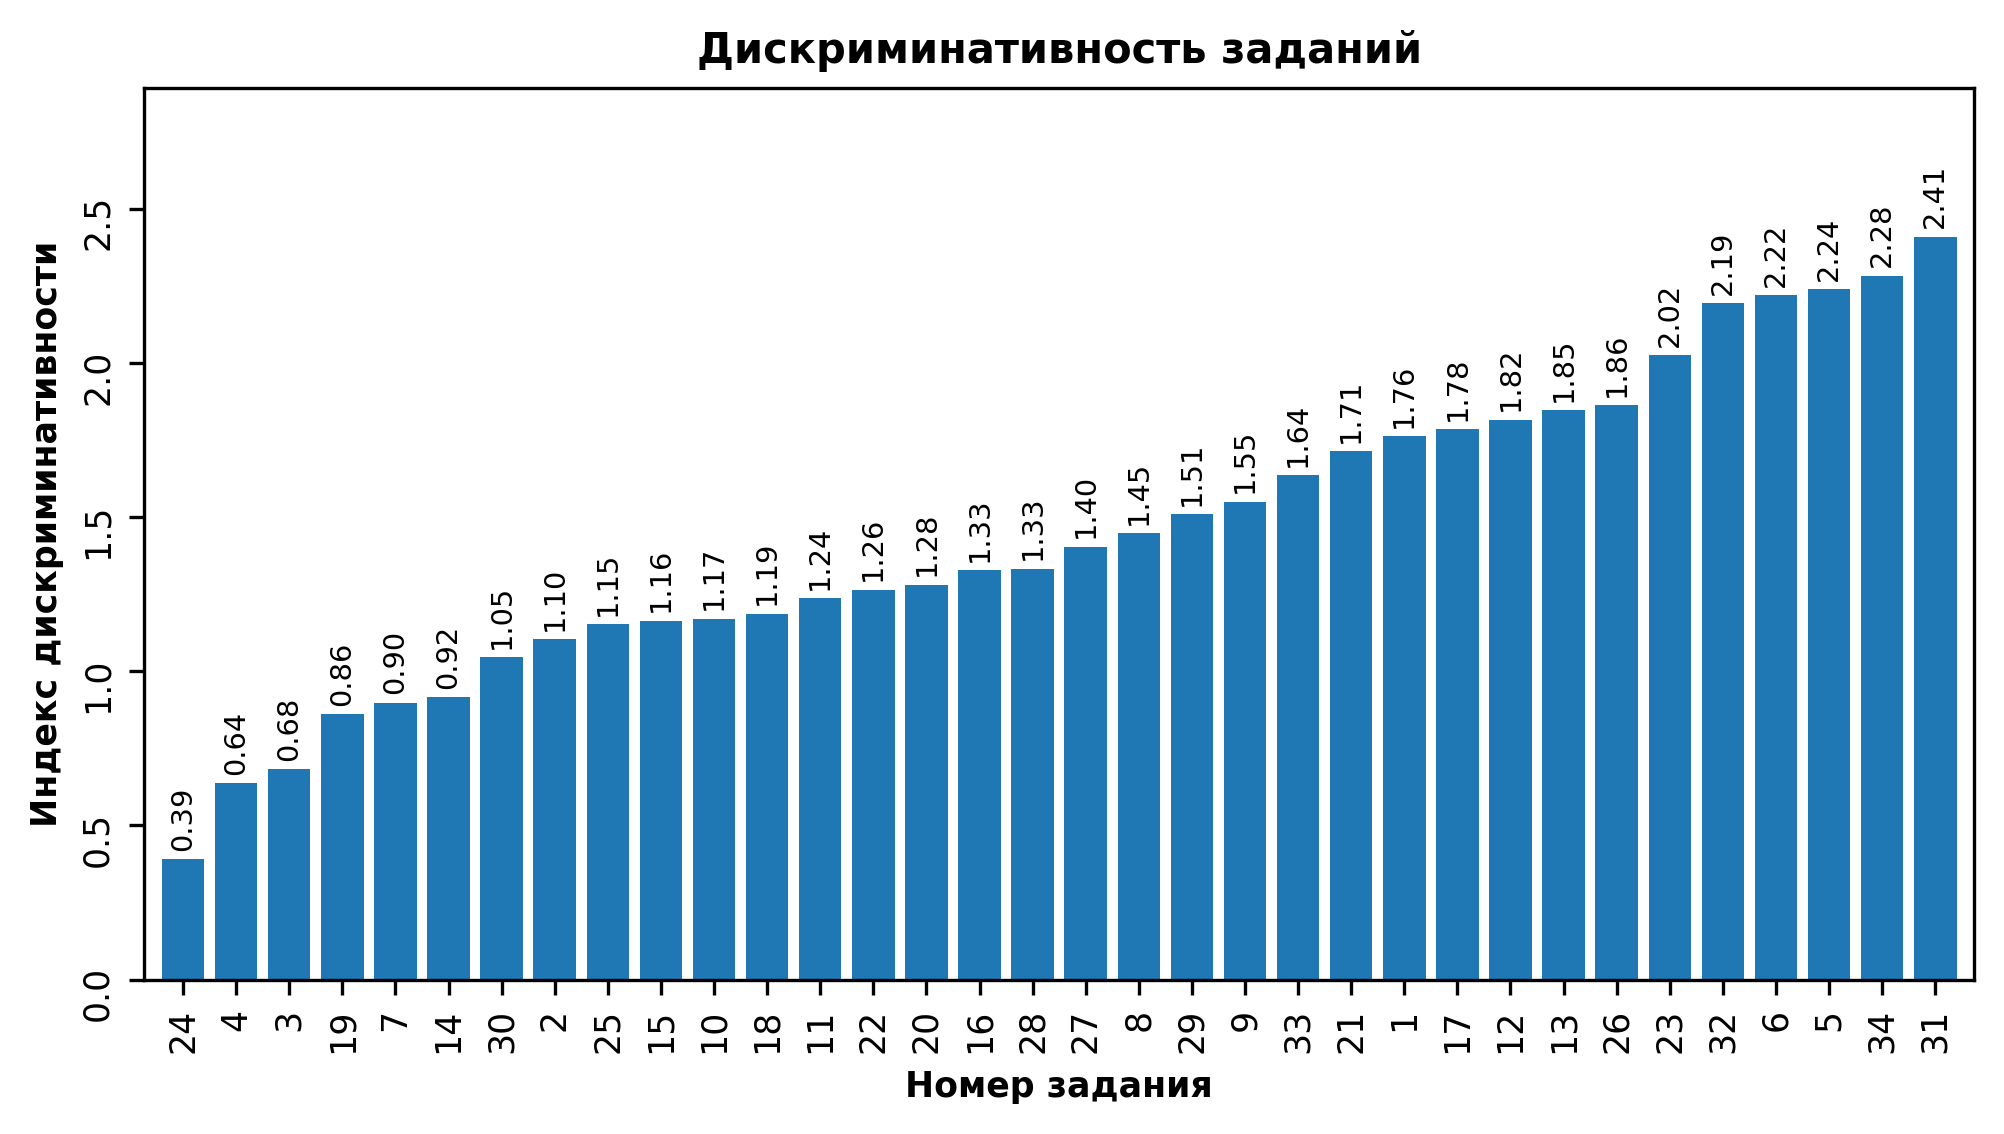

In [30]:
print("2.4. Дискриминативность заданий")

y = discrimination.sort_values(ascending=True)
x = y.index

fig.clear()
ax = fig.add_subplot()
ax.set_xticks(range(len(x)), x + 1)
ax.tick_params(labelsize="small", labelrotation=90)
ax.set_xlabel("Номер задания", fontsize="small", fontweight="bold")
ax.set_ylabel("Индекс дискриминативности", fontsize="small", fontweight="bold")
ax.set_title(
    "Дискриминативность заданий",
    fontsize="medium",
    fontweight="bold",
)
ax.set_xmargin(0.01)
ax.set_ymargin(0.2)
p = ax.bar(range(len(x)), y, width=0.8)
bar_labels = ax.bar_label(
    p,
    padding=2,
    label_type="edge",
    fontsize="x-small",
    rotation="vertical",
    fmt="%0.2f",
)
add_content_to_doc("2.4", "image", fig)
fig

2.5. Стандартная ошибка измерения и погрешность для каждого задания


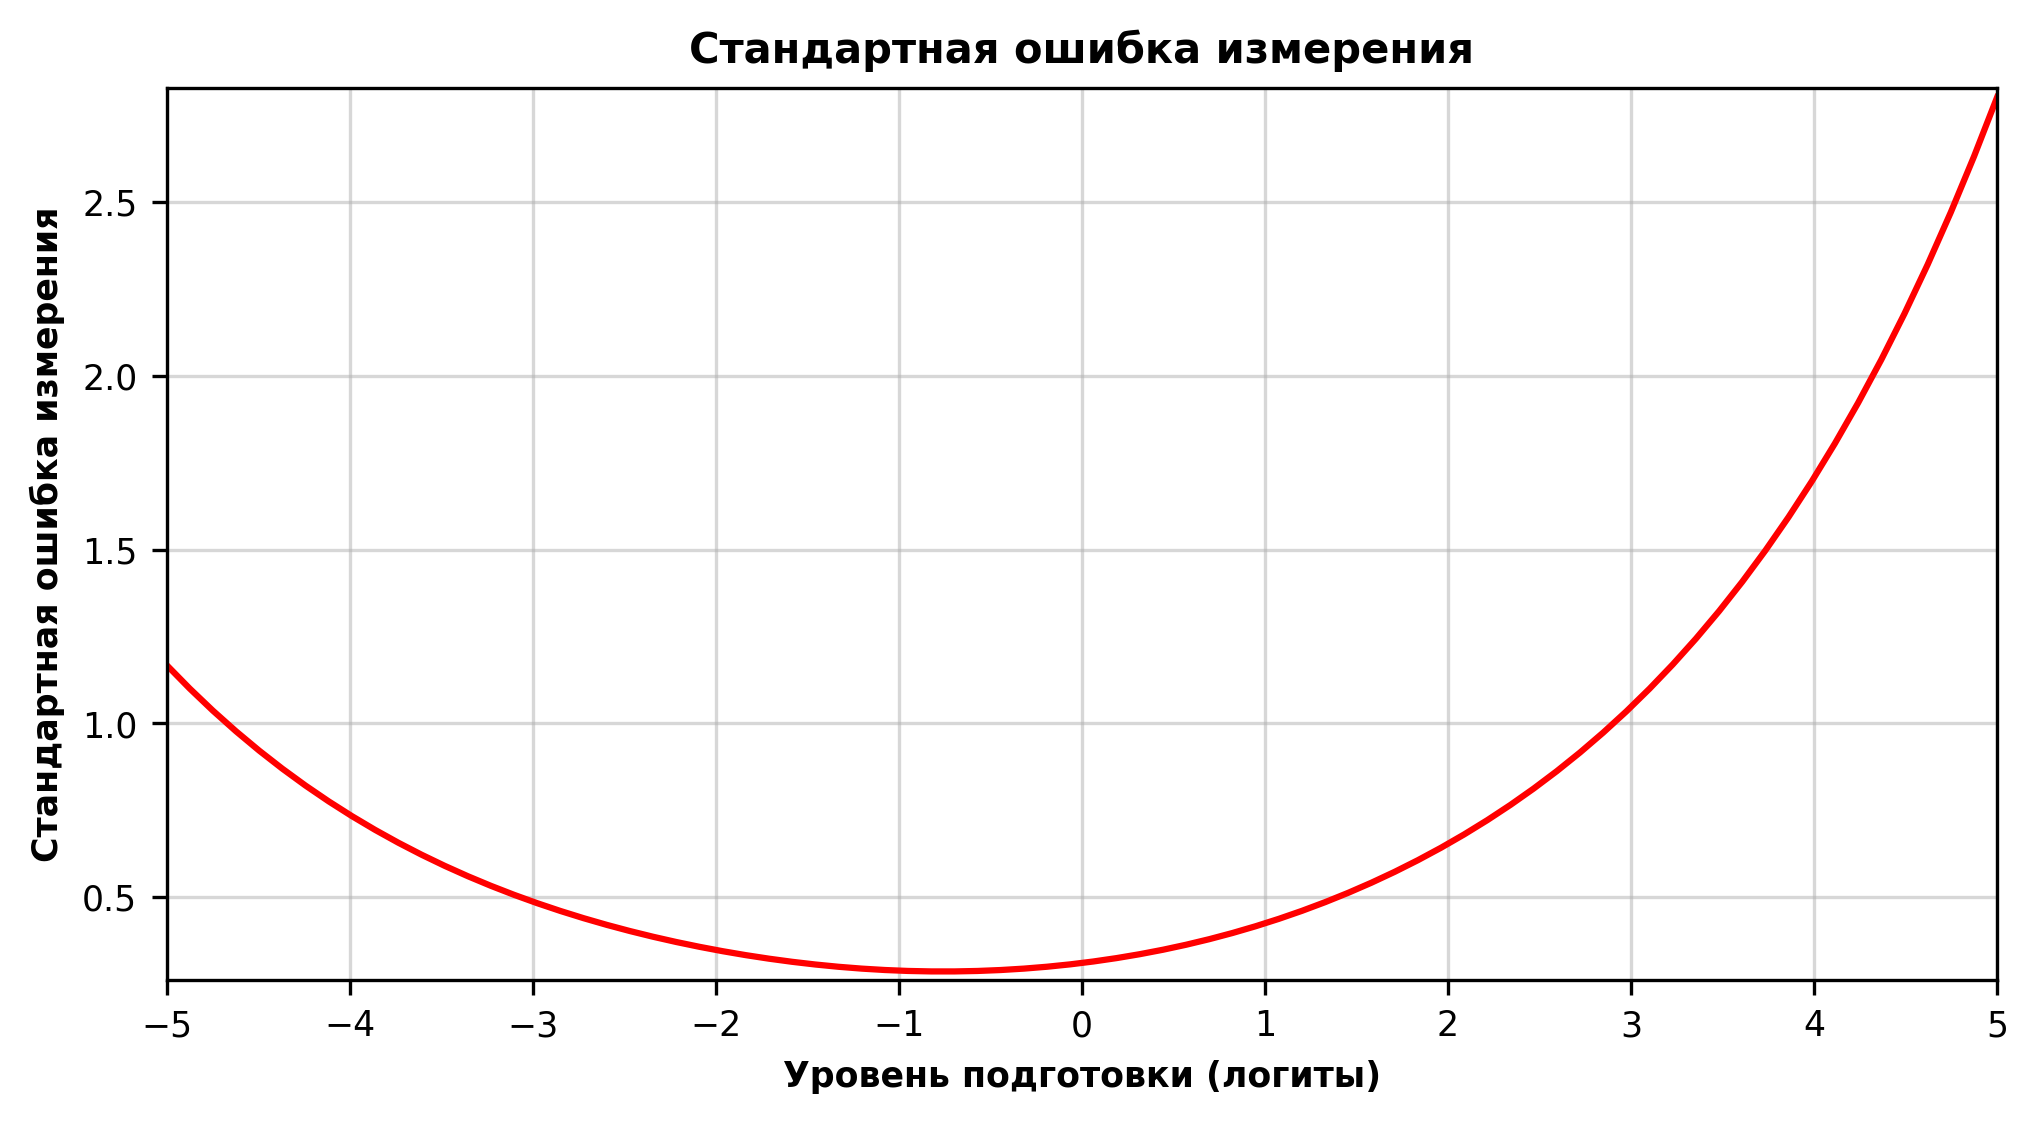

In [31]:
print("2.5. Стандартная ошибка измерения и погрешность для каждого задания")

x = abilities
y = irt_info["se"]

fig.clear()
ax = fig.add_subplot()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.tick_params(labelsize="small")
ax.set_xlabel(
    "Уровень подготовки (логиты)", fontsize="small", fontweight="bold"
)
ax.set_ylabel(
    "Стандартная ошибка измерения", fontsize="small", fontweight="bold"
)
ax.set_title(
    "Стандартная ошибка измерения",
    fontsize="medium",
    fontweight="bold",
)
ax.margins(x=0, y=0.01)
ax.plot(x, y, "r")
ax.grid(True, alpha=0.5)
add_content_to_doc("2.5", "image", fig)
fig

# Doc. gen.

In [33]:
print('Выполнение генерации раздела стат. анализа')

def delete_paragraph(paragraph):
    p = paragraph._element
    p.getparent().remove(p)
    p._p = p._element = None


def add_content(part, p):
    print(f"Содержимое метки {part} сгенерировано")
    for c in doc_content[part]:
        if c["type"] == "text":
            p.insert_paragraph_before(c["text"], style="Normal")
        if c["type"] == "image":
            r = p.insert_paragraph_before(style="Image").add_run()
            r.add_picture(c["path"], width=Inches(17 / 2.54))
    delete_paragraph(p)


doc = Document(template_doc_name)
for paragraph in doc.paragraphs:
    part = paragraph.text[1:-1]
    if part in doc_content:
        add_content(part, paragraph)

doc.save(f"Стат. анализ - {subject_names[subject]}.docx")

Выполнение генерации раздела стат. анализа
Содержимое метки 1.1 сгенерировано
Содержимое метки 1.2 сгенерировано
Содержимое метки 1.3 сгенерировано
Содержимое метки 1.4 сгенерировано
Содержимое метки 1.5 сгенерировано
Содержимое метки 1.6 сгенерировано
Содержимое метки 1.7 сгенерировано
Содержимое метки 1.8 сгенерировано
Содержимое метки 1.9 сгенерировано
Содержимое метки 2.1 сгенерировано
Содержимое метки 2.2 сгенерировано
Содержимое метки 2.3 сгенерировано
Содержимое метки 2.4 сгенерировано
Содержимое метки 2.5 сгенерировано
